In [96]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,precision_score,f1_score
from progress.bar import Bar
%matplotlib inline

In [5]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [6]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [7]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [8]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

#### Dataset

In [23]:
columns1=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','sal']
raw_df=pd.read_csv('adult.data',names=columns1)

In [24]:
raw_df['native_country'] = raw_df['native_country'].str.strip()

In [25]:
#slicing dataset for native_country is united states
usa_df=raw_df[raw_df['native_country']=='United-States']

In [26]:
#slicing dataset for native_country is  not united states
other_df=raw_df[raw_df['native_country']!='United-States']

In [27]:
df=usa_df.copy()#copying dataset to df
df.drop(['capital_gain','capital_loss','education_num','fnlwgt','native_country'],axis=1,inplace=True)

In [28]:
df = pd.get_dummies(df,columns=['sal'],drop_first=True)

In [29]:
cat_feats=['workclass','education','marital_status','occupation','relationship','race','sex']
df = pd.get_dummies(df,columns=cat_feats,drop_first=True)

In [30]:
#partitioning predictor and target variable
y=df['sal_ >50K']
X=df.drop(['sal_ >50K'],axis=1)
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

### Modeling

In [32]:
from xgboost import XGBClassifier
# Instantiate XGBClassifier
model = XGBClassifier()

# Fit XGBClassifier
model.fit(X_train, y_train)
# Predict on training and test sets
training_preds = clf.predict(X_train)
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,training_preds)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

train: 0.9 test: 0.89


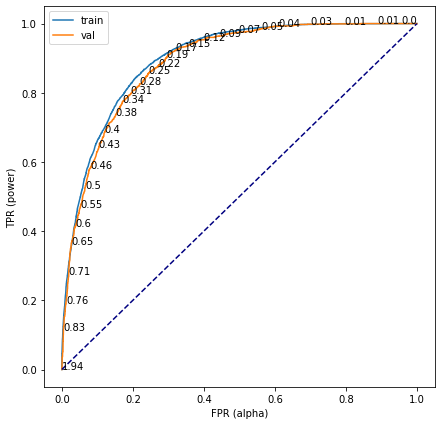

In [33]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

### GridSearch CV with XGBoost

In [37]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold


skf = StratifiedKFold(n_splits=5,random_state=42)
param_grid = {'learning_rate':[lr/100 for lr in range(1,10+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train: 0.9 test: 0.89
{'learning_rate': 0.1}


#### Tuning learning rate and fixed number of estimators for tuning tree-based parameters

In [38]:
param_grid = {'learning_rate':[lr for lr in range(1,10+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 0.92 test: 0.88
{'learning_rate': 1}


#### Tune max_depth and min_child_weight
The ideal values are 5 for max_depth and 5 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [40]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.grid_scores_)
print(opt_model.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'max_depth': 5, 'min_child_weight': 5}


In [41]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.grid_scores_)
print(opt_model.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'max_depth': 4, 'min_child_weight': 4}


###  Tune gamma

In [43]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.grid_scores_)
print(opt_model.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'gamma': 0.3}


#### Tune subsample and colsample_bytree

In [51]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# print(opt_model.grid_scores_)
# print(opt_model.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'colsample_bytree': 0.6, 'subsample': 0.7}


In [62]:
param_test5 = {
 'subsample':[i/100.0 for i in range(50,70,5)],
 'colsample_bytree':[i/100.0 for i in range(60,80,5)]
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'colsample_bytree': 0.6, 'subsample': 0.55}


In [63]:
print(opt_model.best_score_)


0.8947165983132855


### Tuning Regularization Parameters

In [64]:
param_test6 = {
            'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
opt_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.7,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.best_score_)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train: 0.91 test: 0.89
{'reg_alpha': 1e-05}
0.8946076982573137


#### Final model and Threshold calculation

In [94]:
from xgboost import XGBClassifier, plot_importance

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.0,
 subsample=0.55,
 colsample_bytree=0.6,
 reg_alpha=0.00005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb3.fit(X_train,y_train)
best_model = opt_model.best_estimator_
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.best_score_)

#Predict training set:
predictions = xgb3.predict(X_train)
predprob = xgb3.predict_proba(X_train)[:,1]
        
#Print model report:
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, predprob))
                    
#Getting values of FPR,TPR and Threshold at each point of curve
fpr, tpr, threshold = roc_curve(y_train,predprob)







train: 0.91 test: 0.89
{'reg_alpha': 1e-05}
0.8946076982573137

Model Report
Accuracy : 0.8677
AUC Score (Train): 0.926268


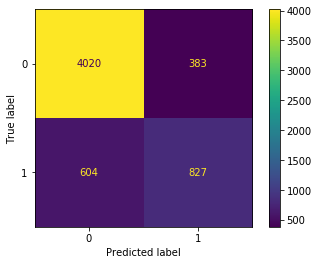

In [120]:
plot_confusion_matrix(xgb3, X_test,y_test,values_format='d')

 ##### Metz(m)=(1-Prevalence/Prevalence)*cost(FP)-cost(TN)/cost(FN)-cost(TP)
 #### fm=TPR-m(FPR)

#### Threshold Calculation(1st Case)if m=1
 This case is applicable for people native to USA,false positive and false negative both cost same. Here we choose m=1
     

In [79]:
#Getting the best threshold(max(TPR-FPR)) for m=1
threshold_chosen = 0
difference = 0
for i in range(len(threshold)):
    temp = tpr[i]-fpr[i]
    if temp>difference:
        difference=temp
        threshold_chosen=threshold[i]
threshold_chosen = round(threshold_chosen,2)
print('Best Threshold:- ',threshold_chosen)

Best Threshold:-  0.22


#### m calculation
#### (1-Prevalence/Prevalence)
#### This case is for people not native to USA.  So our priority will be to avoid people earning less than 50K, to enter USA. We will assign high cost to False Positive cases .Cost of False positive is highest 15, for True negative and false negative is 1 and for True positive is 5.

In [115]:
#from confusion matrix prevalence
pre=0.75

In [116]:
###cost(FP)-cost(TN)/cost(FN)-cost(TP)

c=0.488

In [118]:
m=pre*c
m

0.366

In [119]:
#Getting the best threshold(max(TPR-FPR)) for m=1
threshold_chosen = 0
difference = 0
for i in range(len(threshold)):
    temp = tpr[i]-(m*fpr[i])
    if temp>difference:
        difference=temp
        threshold_chosen=threshold[i]
threshold_chosen = round(threshold_chosen,2)
print('Best Threshold:- ',threshold_chosen)

Best Threshold:-  0.14


#### confusion matrix

In [97]:


from sklearn.metrics import confusion_matrix
y_pred = np.where(xgb3.predict_proba(X_val)[:,1] > threshold_chosen, 1, 0)
print ('Accuracy score:', round(accuracy_score(y_val, y_pred),2))
print ('Recall score:', round(recall_score(y_val, y_pred), 2))
print ('Precision score:', round(precision_score(y_val, y_pred), 2))
print ('F1 score:', round(f1_score(y_val, y_pred), 2))


Accuracy score: 0.79
Recall score: 0.86
Precision score: 0.55
F1 score: 0.67


#### Variable Importance

['marital_status_ Married-civ-spouse', 0.33423337]
['marital_status_ Never-married', 0.0017743115]
['relationship_ Own-child', 0.030988175]
['education_ Prof-school', 0.026891233]
['relationship_ Unmarried', 0.006721209]
['occupation_ Prof-specialty', 0.063271984]
['education_ Masters', 0.04151464]
['education_ 7th-8th', 0.022321548]
['occupation_ Exec-managerial', 0.06903073]
['education_ Doctorate', 0.017845651]
['occupation_ Other-service', 0.030466896]
['education_ Bachelors', 0.03596556]
['education_ 9th', 0.014625047]
['education_ 11th', 0.017924352]
['education_ 5th-6th', 0.0059278226]
['relationship_ Wife', 0.015101135]
['education_ HS-grad', 0.031721547]
['relationship_ Not-in-family', 0.014254919]
['occupation_ Farming-fishing', 0.017113626]
['occupation_ Handlers-cleaners', 0.015882893]
['occupation_ Tech-support', 0.012574329]
['age', 0.025524108]
['workclass_ Self-emp-inc', 0.0125445835]
['hours_per_week', 0.020596953]
['sex_ Male', 0.011592522]
['workclass_ Federal-gov', 

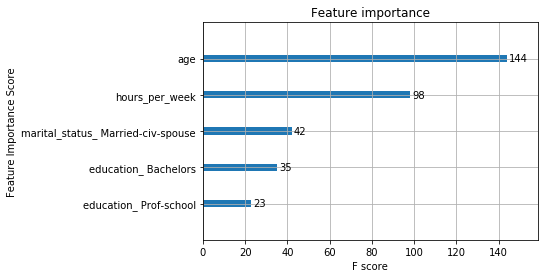

In [80]:
sorted_idx = np.argsort(xgb3.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], model.feature_importances_[index]]) 
plot_importance(model, max_num_features = 5)
plt.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [101]:
from sklearn.metrics import plot_confusion_matrix

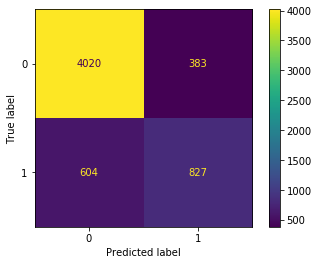

In [111]:
plot_confusion_matrix(xgb3, X_test,y_test,values_format='d')





In [ ]:
# scores(best_model,X_train,X_val,y_train,y_val)
# roc_plot(best_model,X_train,y_train,X_val,y_val)

In [98]:
best_model = xgb3

In [100]:
# scores(best_model,X_val,X_test,y_train,y_test)